!pip install medmnist

# Medical Image Classification with MONAI

!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
%matplotlib inline

!pip install monai[all]

In [35]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.4
Pytorch version: 2.0.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\anaconda3\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: 0.19.2
scipy version: 1.9.1
Pillow version: 9.2.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: 0.15.1+cpu
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional d

## Continue working with OrganMNIST3d 64x64x64

In [36]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marus\.medmnist\organmnist3d_64.npz


In [37]:
root_dir = 'C:/Users/marus/.medmnist/'

In [38]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: C:\Users\marus\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [39]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [166]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        axial, coronal, sagittal = self.extract_2d_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}

        if self.transform:
            data['axial'] = self.transform(data['axial'])
            data['coronal'] = self.transform(data['coronal'])
            data['sagittal'] = self.transform(data['sagittal'])

        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [167]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=128, shuffle=False)

In [198]:
def montage(dataset, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice = 0
    elif flag == 'coronal':
        slice = 1
    else:
        slice = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Slices

c:\Users\marus\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


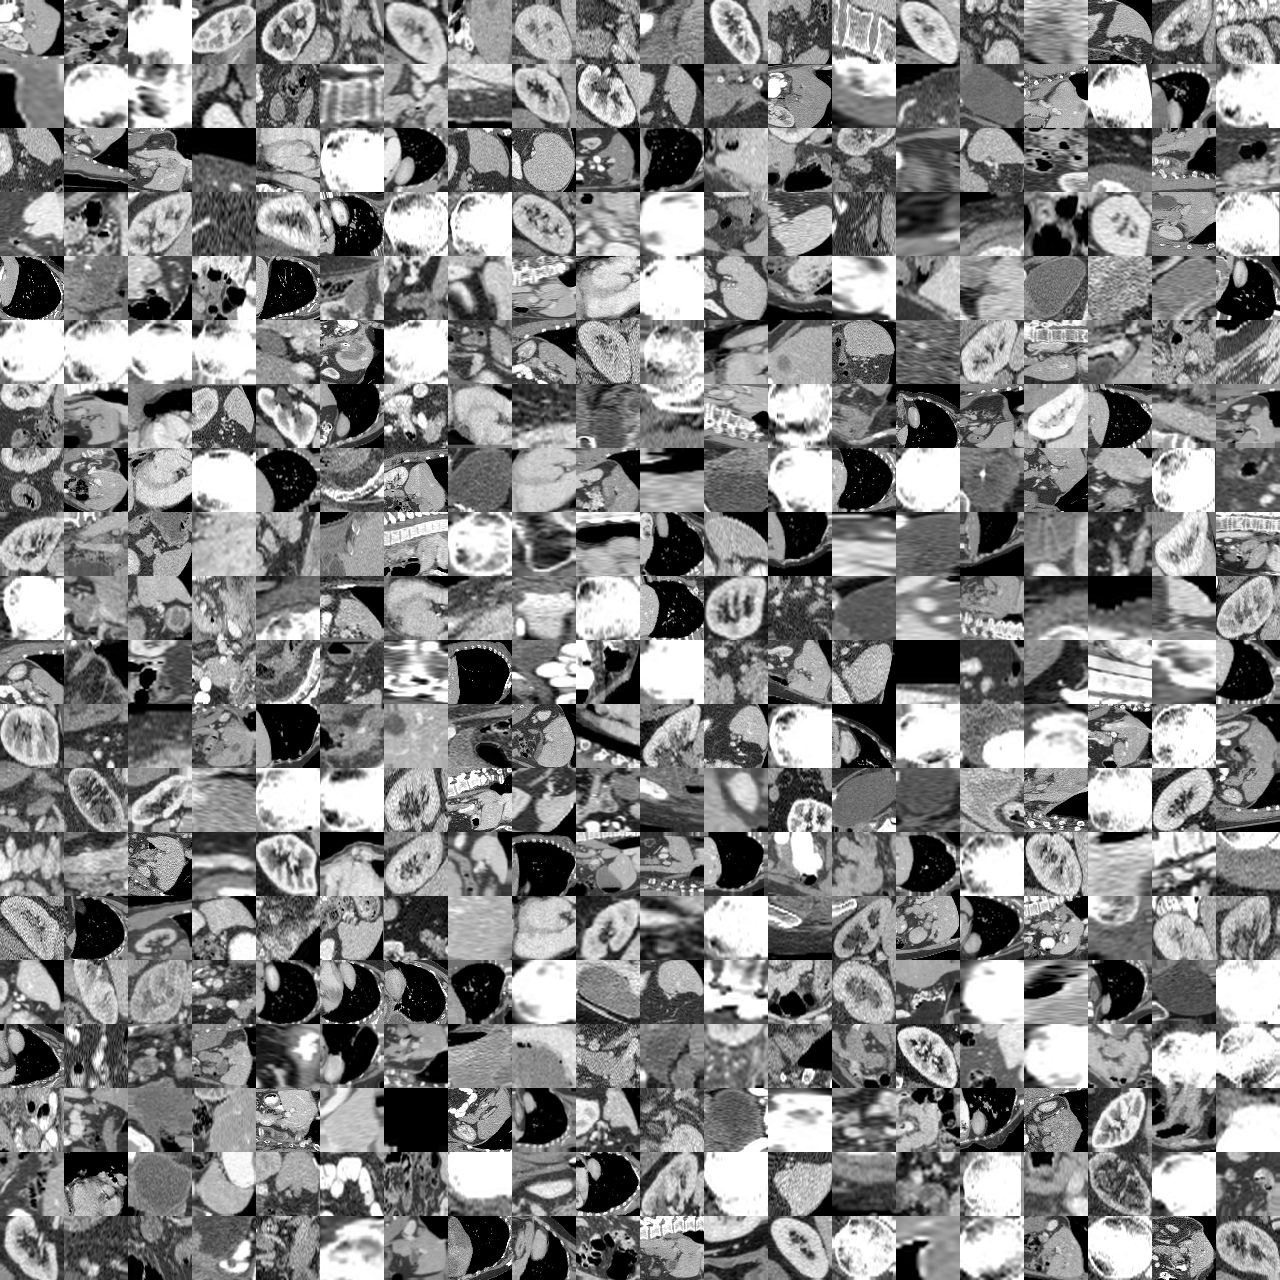

In [199]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'axial')

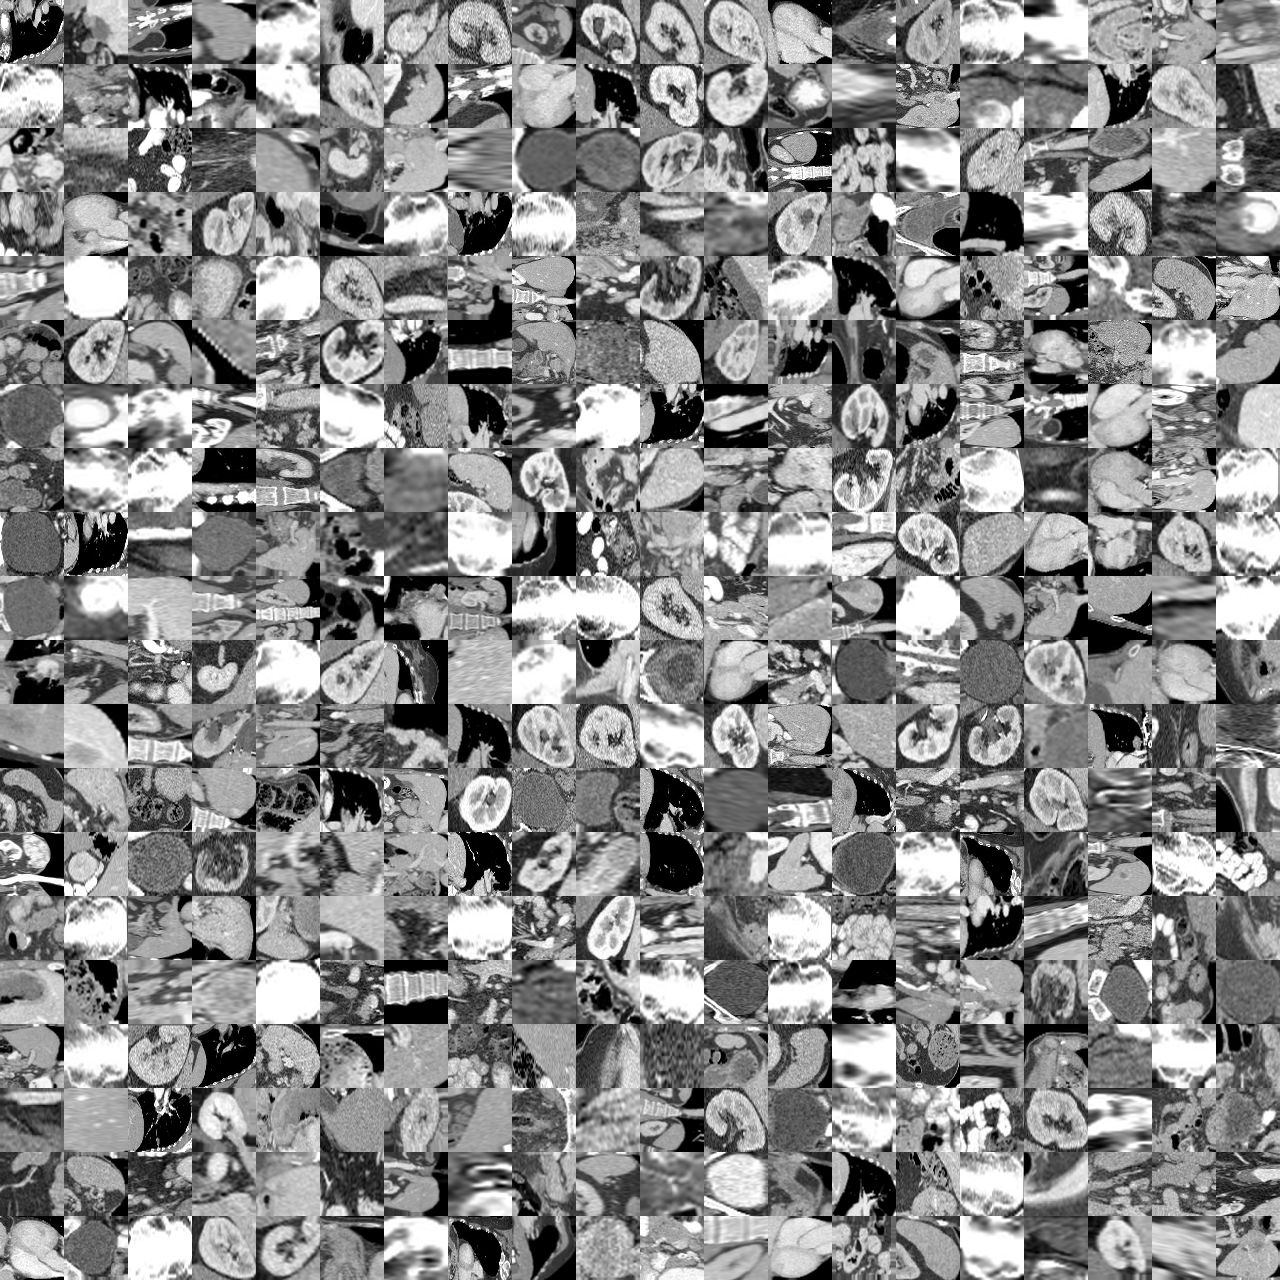

In [202]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'coronal')

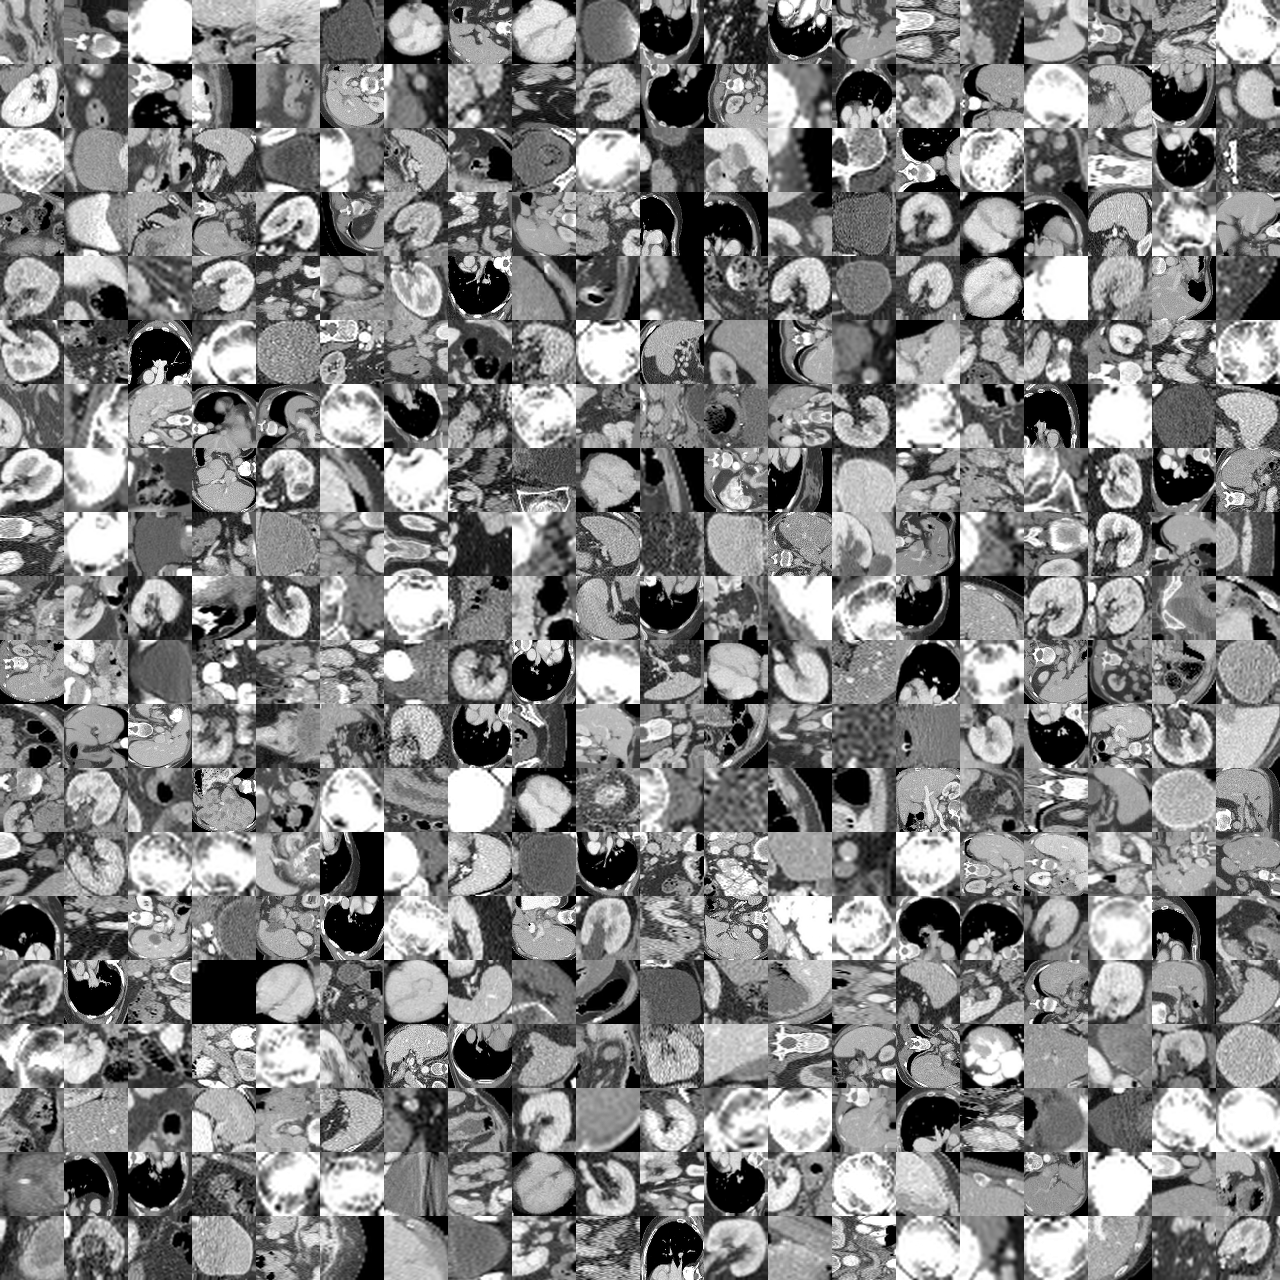

In [201]:
montage(train_dataset_, length=20, replace=False, save_folder='C:/Users/marus/Documents/dataset', flag = 'sagittal')

## Training cycle

In [463]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [472]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/7, train_loss: 1.9790
2/7, train_loss: 2.0043
3/7, train_loss: 2.0709
4/7, train_loss: 2.0087
5/7, train_loss: 2.0189
6/7, train_loss: 1.9901
7/7, train_loss: 1.9902
8/7, train_loss: 1.9897
epoch 1 average loss: 2.0065
1
saved new best metric model
current epoch: 1 current AUC: 0.9053 current accuracy: 0.3789 best AUC: 0.9053 at epoch: 1
----------
epoch 2/4
1/7, train_loss: 2.0267
2/7, train_loss: 2.0134
3/7, train_loss: 1.9579
4/7, train_loss: 1.9048
5/7, train_loss: 1.9256
6/7, train_loss: 2.0152
7/7, train_loss: 1.9550
8/7, train_loss: 1.9972
epoch 2 average loss: 1.9745
1
current epoch: 2 current AUC: 0.9045 current accuracy: 0.4161 best AUC: 0.9053 at epoch: 1
----------
epoch 3/4
1/7, train_loss: 1.9361
2/7, train_loss: 1.9800
3/7, train_loss: 1.9934
4/7, train_loss: 1.9185
5/7, train_loss: 1.8909
6/7, train_loss: 1.8746
7/7, train_loss: 1.8345
8/7, train_loss: 1.9121
epoch 3 average loss: 1.9175
1
saved new best metric model
current epoch: 3 current AUC: 

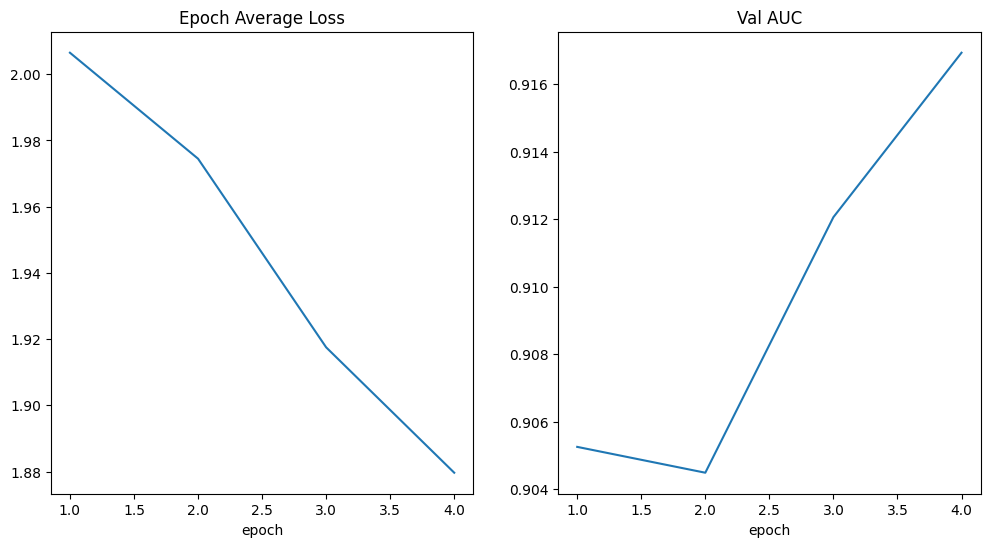

In [473]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [475]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [478]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.5536    0.8986    0.6851        69
           1     0.1953    0.3676    0.2551        68
           2     0.2110    0.3333    0.2584        69
           3     0.4444    0.1231    0.1928        65
           4     0.4821    0.4154    0.4463        65
           5     0.4425    0.7576    0.5587        66
           6     0.0000    0.0000    0.0000        28
           7     0.4643    0.6190    0.5306        21
           8     0.2250    0.4286    0.2951        21
           9     0.3333    0.0145    0.0278        69
          10     0.5000    0.0145    0.0282        69

    accuracy                         0.3590       610
   macro avg     0.3501    0.3611    0.2980       610
weighted avg     0.3729    0.3590    0.2985       610



## Let's repeat the process for coronnal and sagittal parts of the dataset

## Training cycle for the coronal part

In [479]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [480]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/7, train_loss: 2.3742
2/7, train_loss: 2.4102
3/7, train_loss: 2.3611
4/7, train_loss: 2.3936
5/7, train_loss: 2.3764
6/7, train_loss: 2.3931
7/7, train_loss: 2.4138
8/7, train_loss: 2.3165
epoch 1 average loss: 2.3799
1
saved new best metric model
current epoch: 1 current AUC: 0.6119 current accuracy: 0.2298 best AUC: 0.6119 at epoch: 1
----------
epoch 2/4
1/7, train_loss: 2.3134
2/7, train_loss: 2.2865
3/7, train_loss: 2.3686
4/7, train_loss: 2.3058
5/7, train_loss: 2.2842
6/7, train_loss: 2.2661
7/7, train_loss: 2.2761
8/7, train_loss: 2.2711
epoch 2 average loss: 2.2965
1
saved new best metric model
current epoch: 2 current AUC: 0.6564 current accuracy: 0.2422 best AUC: 0.6564 at epoch: 2
----------
epoch 3/4
1/7, train_loss: 2.2714
2/7, train_loss: 2.2898
3/7, train_loss: 2.2438
4/7, train_loss: 2.2293
5/7, train_loss: 2.1916
6/7, train_loss: 2.1826
7/7, train_loss: 2.2314
8/7, train_loss: 2.1458
epoch 3 average loss: 2.2232
1
saved new best metric model
cu

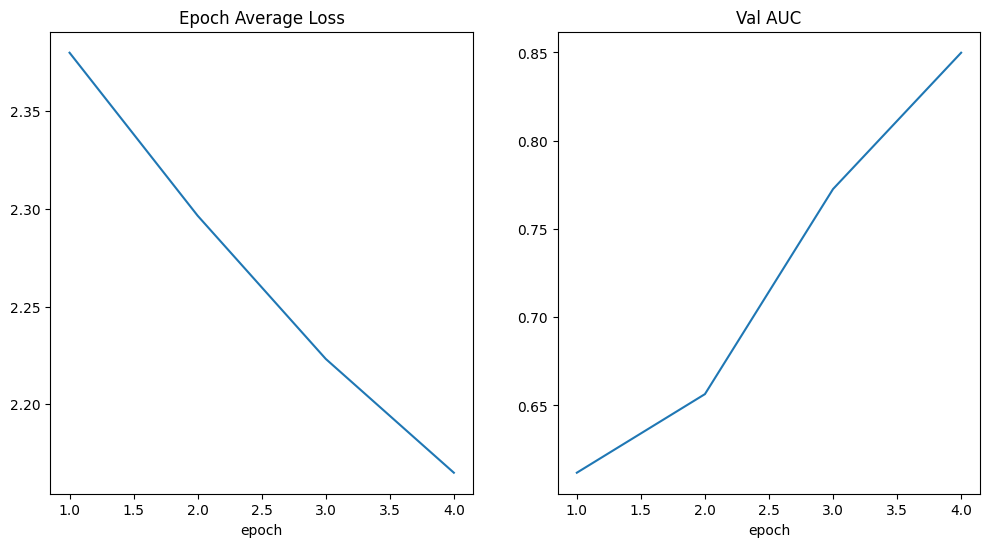

In [481]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [482]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [483]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0     0.8000    0.0580    0.1081        69
           1     0.0000    0.0000    0.0000        68
           2     0.2500    0.0290    0.0519        69
           3     0.1176    0.1231    0.1203        65
           4     0.3676    0.3846    0.3759        65
           5     0.2146    0.8030    0.3387        66
           6     0.0000    0.0000    0.0000        28
           7     0.6000    0.5714    0.5854        21
           8     0.5455    0.2857    0.3750        21
           9     0.0000    0.0000    0.0000        69
          10     0.2527    0.6667    0.3665        69

    accuracy                         0.2557       610
   macro avg     0.2862    0.2656    0.2111       610
weighted avg     0.2617    0.2557    0.1821       610



## Training cycle for the sagittal part

In [484]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

In [485]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/4
1/7, train_loss: 2.4671
2/7, train_loss: 2.4421
3/7, train_loss: 2.4772
4/7, train_loss: 2.4504
5/7, train_loss: 2.4490
6/7, train_loss: 2.4280
7/7, train_loss: 2.3862
8/7, train_loss: 2.3559
epoch 1 average loss: 2.4320
1
saved new best metric model
current epoch: 1 current AUC: 0.5696 current accuracy: 0.0621 best AUC: 0.5696 at epoch: 1
----------
epoch 2/4
1/7, train_loss: 2.3736
2/7, train_loss: 2.3420
3/7, train_loss: 2.3622
4/7, train_loss: 2.3252
5/7, train_loss: 2.3199
6/7, train_loss: 2.3757
7/7, train_loss: 2.2622
8/7, train_loss: 2.2738
epoch 2 average loss: 2.3293
1
saved new best metric model
current epoch: 2 current AUC: 0.6132 current accuracy: 0.1242 best AUC: 0.6132 at epoch: 2
----------
epoch 3/4
1/7, train_loss: 2.2855
2/7, train_loss: 2.2336
3/7, train_loss: 2.2522
4/7, train_loss: 2.2985
5/7, train_loss: 2.2504
6/7, train_loss: 2.2052
7/7, train_loss: 2.1681
8/7, train_loss: 2.2798
epoch 3 average loss: 2.2467
1
saved new best metric model
cu

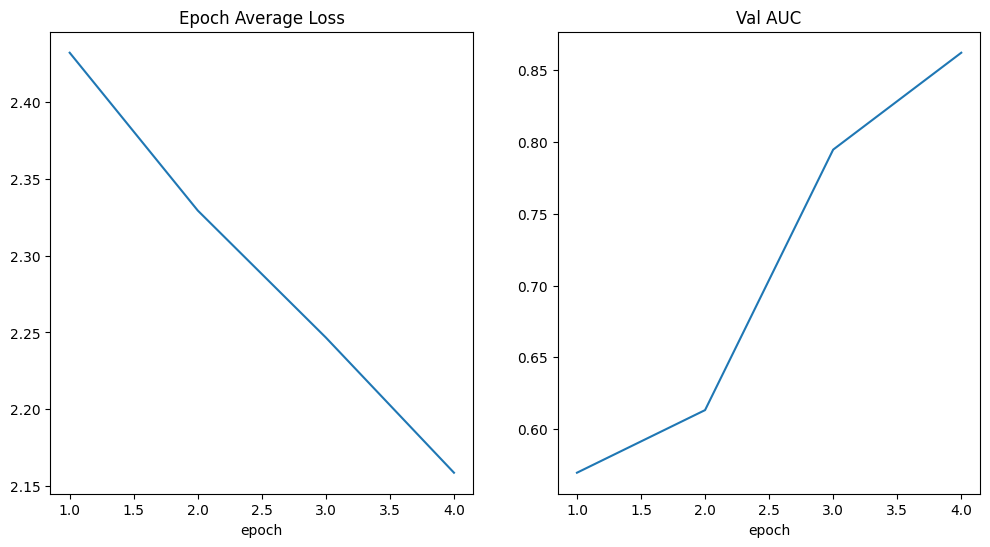

In [486]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

In [487]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [488]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0     0.2500    0.0145    0.0274        69
           1     0.0000    0.0000    0.0000        68
           2     0.2367    0.5797    0.3361        69
           3     0.3333    0.0308    0.0563        65
           4     0.4318    0.5846    0.4967        65
           5     0.2762    0.7576    0.4049        66
           6     0.2500    0.0357    0.0625        28
           7     0.1282    0.7143    0.2174        21
           8     0.0588    0.0952    0.0727        21
           9     0.2500    0.0145    0.0274        69
          10     0.3333    0.0145    0.0278        69

    accuracy                         0.2475       610
   macro avg     0.2317    0.2583    0.1572       610
weighted avg     0.2504    0.2475    0.1630       610

